## draft for run_create_plots()

### tacks :
- mofify the matrix - use integers for columns and rows indices. Maybe plotting will be easier this way

In [3]:
import pandas as pd
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns
sns.set()

import os
import datetime
from time import time

In [ ]:
# raw counter 
def create_bars(df, cov):
    """raw reads count"""
    raw_del_count = df.sum(axis=0)
    fig_raw_count = plt.figure(figsize=(20, 7))

    plt.bar(raw_del_count.index, raw_del_count)
    plt.xticks(list(range(len(raw_del_count))), list(range(1, len(raw_del_count)+1)))
    
    plt.title("all deletion count irrespective deletion length", fontsize=25)
    plt.xlabel("nuc pos", fontsize=25)
    plt.ylabel("count", fontsize=25)
    plt.show()
    

In [14]:
FILE_COUNTER = 0


def get_coverage(file_name):
    """takes out coverage value from
    excel file.
    """
    df_cov = pd.read_excel(file_name, 2)
    cov = int(df_cov["coverage"])
    return cov


def _get_current_time():
    """returns time stamp
    """
    time_stamp = datetime.datetime.fromtimestamp(time()).strftime('%Y-%m-%d %H:%M:%S')
    return time_stamp


def _show_report(total_time):
    """prints out very brief report 
    """
    global FILE_COUNTER
    hours = total_time // 3600
    minutes = (total_time % 3600) // 60
    seconds = total_time % 60
    
    total_files = FILE_COUNTER

    print("""
    
    file processed: {0}
    time taken: {1} hours {2} minutes {3} seconds
    
    the results are in the folder 'output_plots'
    
    ---------------
    ... job finished at {4}
    ---------------
    
    """.format(total_files, hours, minutes, int(seconds), _get_current_time()))
    

def create_matrix(file_name):
    """
    creates matrix (length of indel, position) = number of such indels
    """
    
    cov = get_coverage("./output_indels/" + file_name)
    
    indel_type = ["deletions", "insertions"]
    
    # creating matrix of rows:length of indel, columns:position in the sequence 
    for indel in indel_type:
        df_indels = pd.read_excel("./output_indels/" + file_name, sheet_name=indel)
        container = []
    
        for col in df_indels.columns: 
            indels_total = df_indels.loc[ : , col].tolist()
            lengths = list(set(indels_total))
            lengths = (x for x in lengths if x==x) # deleting 'nan'
            d = OrderedDict()
        
            for length in lengths:
                d[length] = indels_total.count(length)
            container.append(d)
                      
        indel_matrix = pd.DataFrame(container)
    
        # adding missing values to df columns with empty values
        # as we don't have all lengths of indels
        # it's for accurate plots
        
        
        try:
            max_col_ind = int(max(indel_matrix.columns))
            for i in range(1, max_col_ind):
                if i not in indel_matrix.columns:
                    indel_matrix[i] = np.nan # adding missing value ('indel length') to column with empty values
       
            indel_matrix = indel_matrix.T
            indel_matrix.sort_index(axis=0, ascending=False, inplace=True)
            indel_matrix.columns = df_indels.columns
    
            create_bars_percent(file_name, indel_matrix, cov, indel)
            create_heatmap(file_name, indel_matrix, indel)
        
        # trying to catch empty excel tabs
        except ValueError as e:
            print(e, """perhaps the excel tab is empty. 
            the {0} for file {1} won't be written
            """.format(indel, file_name))
        
        #return indel_matrix
        
        
def create_bars_percent(file_name, indel_matrix, cov, indel):
    """percent reads count 
    based on coverage
    """
    raw_del_count = indel_matrix.sum(axis=0)
    fig_del_percent = plt.figure(figsize=(20, 7))
    perc_del_count = raw_del_count / cov * 100

    plt.bar(perc_del_count.index, perc_del_count)
    plt.xticks(list(range(len(raw_del_count))), list(range(1, len(raw_del_count)+1)))
    
    plt.title("percent of" + indel, fontsize=25)
    plt.xlabel("nucleotide position", fontsize=25)
    plt.ylabel("percent", fontsize=25)
    
    if not os.path.exists("./output_plots"):
        os.mkdir("output_plots")
    #plt.show() # comment to save figure, otherwise it'll save blank file
    fig_del_percent.savefig("./output_plots/" + file_name.rsplit(".", 1)[0] + "_bars_" + indel + ".png")
    plt.close() # comment the line to show the figure in the jupyter or wherever
    

    
def create_heatmap(file_name, indel_matrix, indel):

    cmap = plt.cm.jet # defining colormap
    cmaplist = [cmap(i) for i in range(cmap.N)] # list of colors from jet map
    cmap_short = cmaplist[130:]
    cmap_short[0] = (.5, .5, .5, 1.0) # first entry changed to be grey
    
    # here's the max value of indels in the current df
    # it's used to denote the largest value in colormap and split colormap into segments
    largest_indel_num = indel_matrix.max()
    largest_indel_num = int(largest_indel_num.max()) # turning into int class numpy float, otherwise deprecation warning is raised

    fig = plt.figure(figsize=(25, 8))
    ax = plt.axes()

    sns.heatmap(indel_matrix, cmap=cmap_short, annot=True)
    plt.yticks(list(range(1, len(indel_matrix.index) + 1)), 
               list(reversed(range(1, len(indel_matrix.index) + 1))), 
               fontsize=12, horizontalalignment="left")

    plt.xlabel("nucleotide position", fontsize=20)
    plt.ylabel("length of indel", fontsize=20)

    plt.title("number and length of " + indel, fontsize=25)
    #plt.xticks(list(range(1, len(matrix.columns) + 1)), list(range(1, len(matrix.columns) + 1)), fontsize=15)
    #plt.show() # comment to save figure, otherwise it'll save blank file
    fig.savefig("./output_plots/" + file_name.rsplit(".", 1)[0] + "_heatmap_" + indel + ".png")
    plt.close() # comment the line to show the figure in the jupyter or wherever

    
def run_create_plots():
    """main functions
    """
    start_time = time()
    
    print("""
    ---------------
    job started at {0} ...
    ---------------
    """.format(_get_current_time()))
    
    if os.path.exists("./output_indels"):
        input_sheets = os.listdir("./output_indels")

        for f in input_sheets:
            if os.path.isdir("./output_indels/" + f):
                print("""\nwarning: please, don't put folders into the 'output_indels' folder
                I believe this is a folder: '{0}'""".format(f) + "\n")
            elif f.rsplit(".", 1)[-1] == "xlsx":
                print("processing file '{}'".format(f))
                print(f)
                create_matrix(f)
            else:
                print(
                    "\nwarning: item '{0}' isn't a fasta file. it won't be processed\n".format(f))
        else:
            finish_time = time()
            total_time = finish_time - start_time
            _show_report(total_time)
    else:
        print(
            """
        Houston, we have a problem...
        --------
        folder 'output_indels' doesn't exist in the current directory 
        or may be you've renamed it but misspelled its name.
        Please, check it out.
        --------
        """
        )    
    
if __name__ == "__main__":
    run_create_plots()
    

    

In [15]:
run_create_plots()


    ---------------
    job started at 2018-10-17 11:50:30 ...
    ---------------
    
processing file 'DK-14-10_S218_R1_1_400,510R.xlsx'
DK-14-10_S218_R1_1_400,510R.xlsx
processing file 'DK-14-3_S220_R1_1_1,096,545R.xlsx'
DK-14-3_S220_R1_1_1,096,545R.xlsx
processing file 'DK-14-5_S221_R1_001 assembled to OT14-5.xlsx'
DK-14-5_S221_R1_001 assembled to OT14-5.xlsx
processing file 'DK-cas14-10_S228_R1_1_415,741R.xlsx'
DK-cas14-10_S228_R1_1_415,741R.xlsx
processing file 'DK-cas14-10_S228_R1_2.xlsx'
DK-cas14-10_S228_R1_2.xlsx
processing file 'DK-cas14-10_S228_R1_3.xlsx'
DK-cas14-10_S228_R1_3.xlsx
processing file 'DK-cas14-10_S228_R2_001 assembled to ST 10 off.xlsx'
DK-cas14-10_S228_R2_001 assembled to ST 10 off.xlsx
processing file 'DK-cas14-3_S230_R1_001 assembled to OT14-3.xlsx'
DK-cas14-3_S230_R1_001 assembled to OT14-3.xlsx
processing file 'DK-cas14-5_S231_R1_1_717,246.xlsx'
DK-cas14-5_S231_R1_1_717,246.xlsx
max() arg is an empty sequence perhaps the excel tab is empty. 
            t

PermissionError: [Errno 13] Permission denied: './output_indels/~$DK-cas14-5_S231_R1_1_717,246.xlsx'

In [82]:
create_bars_percent(matrix, coverage, "DK-14-3_S220_R1_1_1,096,545R.xlsx" )

In [16]:
# taking 0 tab to get deletion matrix
matrix = create_matrix("DK-14-3_S220_R1_1_1,096,545R.xlsx", 0)

In [56]:
coverage = get_coverage("DK-14-3_S220_R1_1_1,096,545R.xlsx")

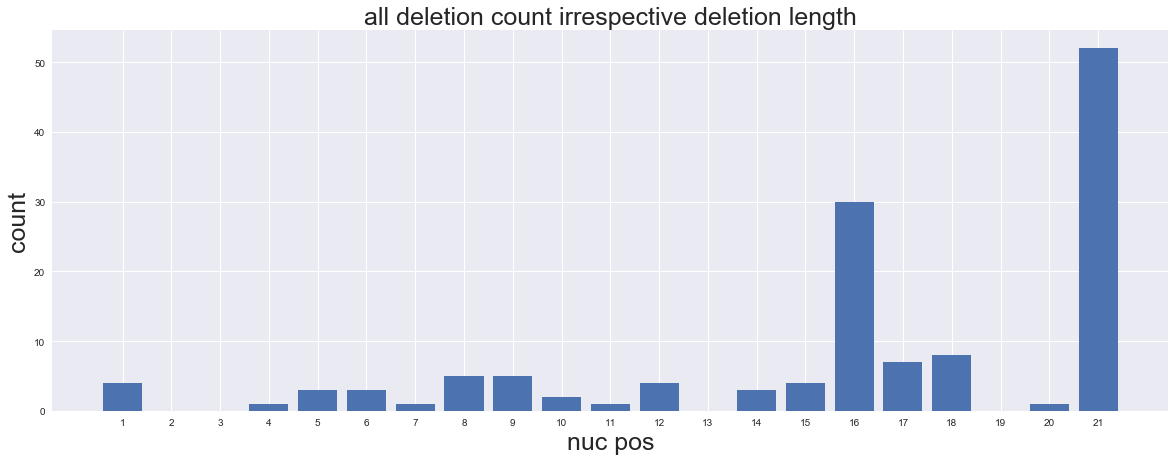

In [57]:
create_bars(matrix, coverage)

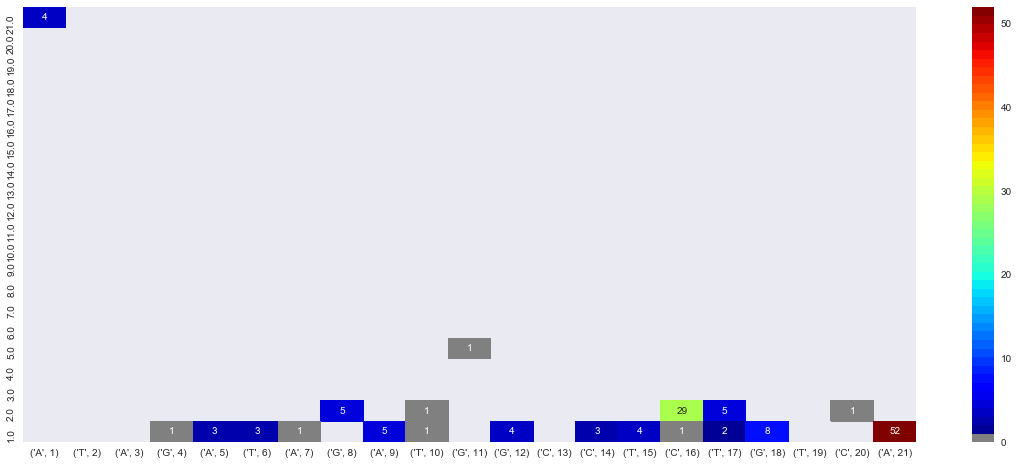

In [21]:
# sketch for heatmap with custom color code :



cmap = plt.cm.jet # defining colormap

cmaplist = [cmap(i) for i in range(cmap.N)] # list of colors from jet map

cmaplist[0] = (.5, .5, .5, 1.0) # first entry changed to be grey

# creating new map
cmap = cmap.from_list("number of indels", cmaplist, cmap.N)


# here's the max value of indels in the current df
# it's used to denote the largest value in colormap and split colormap into segments
largest_indel_num = matrix.max()
largest_indel_num = int(largest_indel_num.max()) # turning into int class numpy float, otherwise deprecation warning is raised

# creating bounds based on the largest indel number
bounds = np.linspace(0, largest_indel_num, largest_indel_num) 
# generating colormap index (boundaries, num of colors to be used)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N) 


fig = plt.figure(figsize=(20, 8))
sns.heatmap(matrix, cmap=cmap,norm=norm, annot=True)

plt.show()



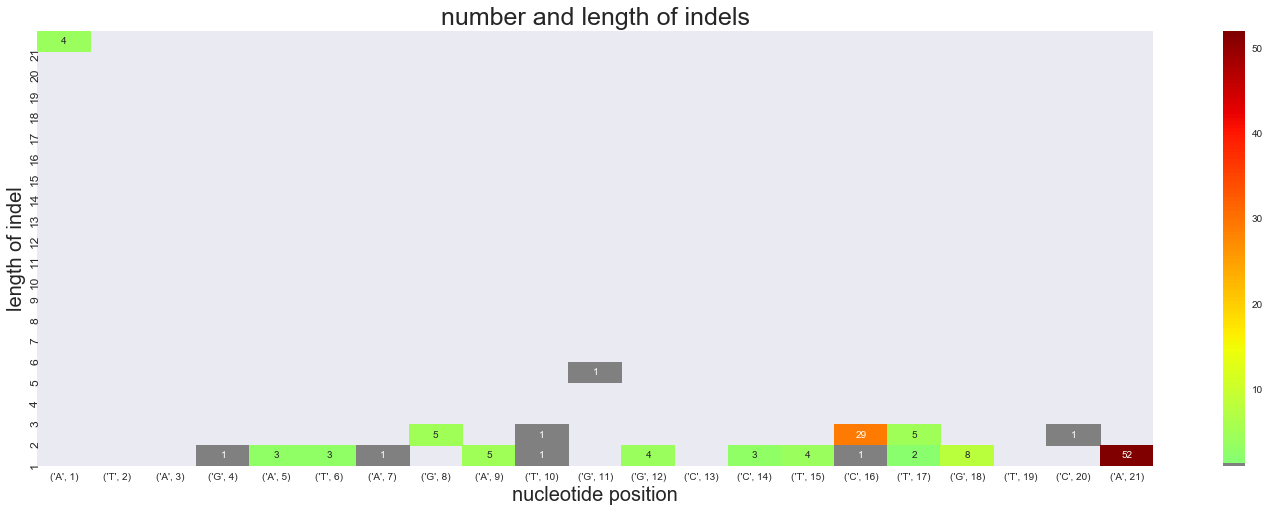

In [75]:
# sketch for heatmap with custom color code :


def create_heatmap(file_name, indel_matrix, indel):

    cmap = plt.cm.jet # defining colormap
    cmaplist = [cmap(i) for i in range(cmap.N)] # list of colors from jet map
    cmap_short = cmaplist[130:]
    cmap_short[0] = (.5, .5, .5, 1.0) # first entry changed to be grey
    
    # here's the max value of indels in the current df
    # it's used to denote the largest value in colormap and split colormap into segments
    largest_indel_num = indel_matrix.max()
    largest_indel_num = int(largest_indel_num.max()) # turning into int class numpy float, otherwise deprecation warning is raised

    fig = plt.figure(figsize=(25, 8))
    ax = plt.axes()

    sns.heatmap(indel_matrix, cmap=cmap_short, annot=True)
    plt.yticks(list(range(1, len(indel_matrix.index) + 1)), 
               list(reversed(range(1, len(indel_matrix.index) + 1))), 
               fontsize=12, horizontalalignment="left")



    plt.xlabel("nucleotide position", fontsize=20)
    plt.ylabel("length of indel", fontsize=20)

    plt.title("number and length of " + indel, fontsize=25)
    #plt.xticks(list(range(1, len(matrix.columns) + 1)), list(range(1, len(matrix.columns) + 1)), fontsize=15)
    #plt.show() # comment to save figure, otherwise it'll save blank file
    fig.savefig("./output_plots/" + file_name.rsplit(".", 1)[0] + "_heatmap_" + indel + ".png")
    plt.close() # comment the line to show the figure in the jupyter or wherever




### here the method in the loop at the bottom of the cell works, it actually shifts the label but only slightly 
### >>>>>>>>>> to cheetsheet

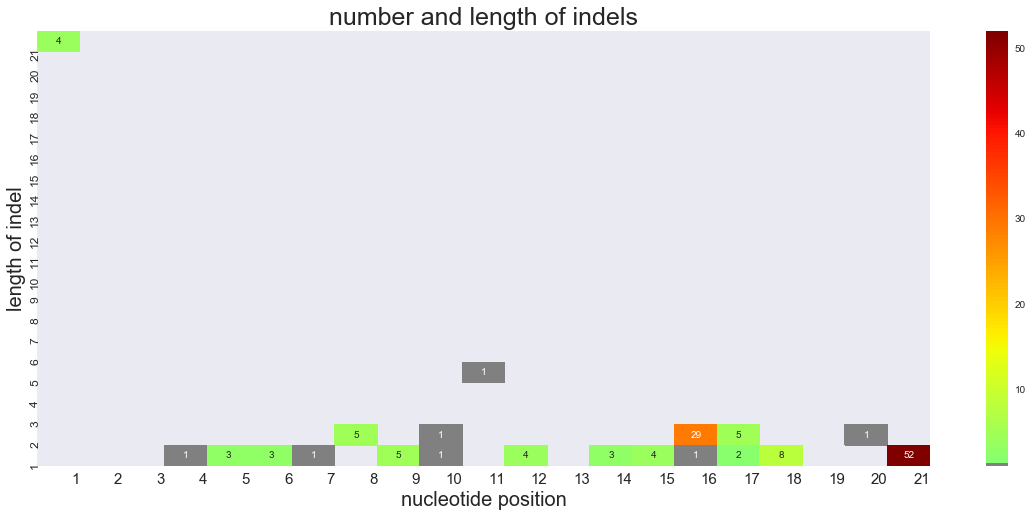

In [91]:

cmap = plt.cm.jet # defining colormap

cmaplist = [cmap(i) for i in range(cmap.N)] # list of colors from jet map

cmap_short = cmaplist[130:]

cmap_short[0] = (.5, .5, .5, 1.0) # first entry changed to be grey


# here's the max value of indels in the current df
# it's used to denote the largest value in colormap and split colormap into segments
largest_indel_num = matrix.max()
largest_indel_num = int(largest_indel_num.max()) # turning into int class numpy float, otherwise deprecation warning is raised


fig, ax = plt.subplots(figsize=(20, 8))

sns.heatmap(matrix, cmap=cmap_short, annot=True)


plt.yticks(list(range(1, len(matrix.index) + 1)), list(reversed(range(1, len(matrix.index) + 1))), fontsize=12, 
           horizontalalignment="left")
plt.xlabel("nucleotide position", fontsize=20)
plt.ylabel("length of indel", fontsize=20)

plt.title("number and length of indels", fontsize=25)

plt.xticks(list(range(1, len(matrix.columns) + 1)), list(range(1, len(matrix.columns) + 1)), fontsize=15)

################
# trying to shift the label 
for tick in ax.xaxis.get_majorticklabels():
    tick.set_horizontalalignment("right")


plt.show()

example from :
https://matplotlib.org/gallery/ticks_and_spines/centered_ticklabels.html


In [ ]:
import numpy as np
import matplotlib.cbook as cbook
import matplotlib.dates as dates
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

# load some financial data; apple's stock price
with cbook.get_sample_data('aapl.npz') as fh:
    r = np.load(fh)['price_data'].view(np.recarray)
r = r[-250:]  # get the last 250 days
# Matplotlib works better with datetime.datetime than np.datetime64, but the
# latter is more portable.
date = r.date.astype('O')

fig, ax = plt.subplots()
ax.plot(date, r.adj_close)

ax.xaxis.set_major_locator(dates.MonthLocator())
ax.xaxis.set_minor_locator(dates.MonthLocator(bymonthday=15))

ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%b'))

for tick in ax.xaxis.get_minor_ticks():
    tick.tick1line.set_markersize(0)
    tick.tick2line.set_markersize(0)
    tick.label1.set_horizontalalignment('center')

imid = len(r) // 2
ax.set_xlabel(str(date[imid].year))
plt.show()